In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import numpy as np
from nilearn import plotting
import clinicadl
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import log_loss
from collections import OrderedDict
from PIL import Image
from tqdm import tqdm
from math import floor
import pickle
import random

# torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# clinicaDL
from clinicadl.tools.tsv.data_split import create_split
from clinicadl.tools.deep_learning.data import generate_sampler, return_dataset, MRIDataset, MRIDatasetImage, MRIDatasetSlice, get_transforms
from torch.utils.data import DataLoader
from clinicadl.tools.deep_learning.cnn_utils import train, get_criterion, test
from clinicadl.tools.deep_learning.models.random import RandomArchitecture
from clinicadl.tools.deep_learning import EarlyStopping

/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [3]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
from tools.explanations.evaluation import *
from tools.explanations.GradCam import *
from train.train_CNN import *
from tools.callbacks import *

In [5]:
data_path = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021.tsv'
summary_path = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021_summary.tsv'
df_data = pd.read_csv(data_path,sep='\t',nrows=10)
df_summary = pd.read_csv(summary_path,sep='\t',nrows=10)

In [6]:
file = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021/subjects/sub-ADNI052S1251/ses-M00/deeplearning_prepare_data/image_based/t1_linear/sub-ADNI052S1251_ses-M00_T1w_space-MNI152NLin2009cSym_desc-Crop_res-1x1x1_T1w.pt'
ts = torch.load(file)
ts.shape

torch.Size([1, 169, 208, 179])

In [7]:
input_type = ''
network_type = ''
caps_directory = ''
preprocessing = ''
tsv_path = ''

# Iterator

In [62]:
class MRIDatasetImage(MRIDataset):
    """Dataset of MRI organized in a CAPS folder."""

    def __init__(self, caps_directory, data_file,
                 preprocessing='t1-linear', train_transformations=None,
                 labels=True, all_transformations=None, multi_cohort=False,
                 df_add_data=None):
        """
        Args:
            caps_directory (string): Directory of all the images.
            data_file (string or DataFrame): Path to the tsv file or DataFrame containing the subject/session list.
            preprocessing (string): Defines the path to the data in CAPS.
            train_transformations (callable, optional): Optional transform to be applied only on training mode.
            labels (bool): If True the diagnosis will be extracted from the given DataFrame.
            all_transformations (callable, options): Optional transform to be applied during training and evaluation.
            multi_cohort (bool): If True caps_directory is the path to a TSV file linking cohort names and paths.
            df_add_data (DataFrame): dataframe containing additional data to predict, such as volumes
        """
        self.df_add_data = df_add_data
        
        self.elem_index = None
        self.mode = "image"
        super().__init__(caps_directory, data_file, preprocessing,
                         augmentation_transformations=train_transformations, labels=labels,
                         transformations=all_transformations, multi_cohort=multi_cohort)

    def __getitem__(self, idx):
        participant, session, cohort, _, label = self._get_meta_data(idx)

        image_path = self._get_path(participant, session, cohort, "image")
        image = torch.load(image_path)

        if self.transformations:
            image = self.transformations(image)

        if self.augmentation_transformations and not self.eval_mode:
            image = self.augmentation_transformations(image)
            
        ## fetch additional data
        temp_df = self.df_add_data[(self.df_add_data.participant_id == participant) &
                                   (self.df_add_data.session_id == session)]
        sex = (temp_df.sex.to_numpy().item() == 'F') + 0.
        age = temp_df.age.to_numpy().item()
        volumes = temp_df.drop(columns=['participant_id', 'session_id', 'sex', 'age']).to_numpy().squeeze()

        sample = {'image': image, 'label': label, 'participant_id': participant, 'session_id': session,
                  'image_path': image_path, 'age': age, 'sex': sex, 'volumes': volumes}

        return sample

    def num_elem_per_image(self):
        return 1


# Models

In [86]:
class Net(nn.Module):
    def __init__(self, sample, convolutions):
        super().__init__()
        self.image_size = sample['image'].shape
        self.features = nn.Sequential()
        input_size = self.image_size[0]
        d_h_w = self.image_size[1:]

        # default parameters
        kernel_size = 3

        for index, nb_conv in enumerate(convolutions):
            self.features.add_module('conv' + str(index), nn.Conv3d(input_size, nb_conv, kernel_size))
            d_h_w = self.conv_output_shape(d_h_w, 3)
            self.features.add_module('relu' + str(index), nn.ReLU())
            self.features.add_module('bnn' + str(index), nn.BatchNorm3d(nb_conv))
            self.features.add_module('pool' + str(index), nn.MaxPool3d(2, 2))
            d_h_w = self.conv_output_shape(d_h_w, 2, stride=2)
            input_size = nb_conv

        self.features_output_size = np.prod(d_h_w) * nb_conv
        self.dense_size_1 = 32
        self.dense_size_2 = 16

        # disease
        self.branch1 = nn.Sequential(
            nn.Linear(self.features_output_size, self.dense_size_1),
            nn.ReLU(),
            nn.BatchNorm1d(self.dense_size_1),
            nn.Linear(self.dense_size_1, self.dense_size_2),
            nn.ReLU(),
            nn.BatchNorm1d(self.dense_size_2),
            nn.Linear(self.dense_size_2, 1),
            nn.Sigmoid()
        )
        # volumes
        n_volumes = np.prod(sample['volumes'].shape)
        self.branch2 = nn.Sequential(
            nn.Linear(self.features_output_size, 4 * n_volumes),
            nn.ReLU(),
            nn.BatchNorm1d(4 * n_volumes),
            nn.Linear(4 * n_volumes, 2 * n_volumes),
            nn.ReLU(),
            nn.BatchNorm1d(2 * n_volumes),
            nn.Linear(2 * n_volumes, n_volumes)
        )
        # age
        self.branch3 = nn.Sequential(
            nn.Linear(self.features_output_size, self.dense_size_1),
            nn.ReLU(),
            nn.BatchNorm1d(self.dense_size_1),
            nn.Linear(self.dense_size_1, self.dense_size_2),
            nn.ReLU(),
            nn.BatchNorm1d(self.dense_size_2),
            nn.Linear(self.dense_size_2, 1)
        )
        # sex
        self.branch4 = nn.Sequential(
            nn.Linear(self.features_output_size, self.dense_size_1),
            nn.ReLU(),
            nn.BatchNorm1d(self.dense_size_1),
            nn.Linear(self.dense_size_1, self.dense_size_2),
            nn.ReLU(),
            nn.BatchNorm1d(self.dense_size_2),
            nn.Linear(self.dense_size_2, 1),
            nn.Sigmoid()
        )

    @staticmethod
    def conv_output_shape(d_h_w, kernel_size=1, stride=1, pad=0, dilation=1):
        if type(kernel_size) is not tuple:
            kernel_size = (kernel_size, kernel_size, kernel_size)
        new_d_h_w = []
        for k in range(len(d_h_w)):
            new_d_h_w.append(floor(((d_h_w[k] + (2 * pad) - (dilation * (kernel_size[k] - 1)) - 1) / stride) + 1))
        return new_d_h_w

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.features_output_size)
        c = self.branch1(x)
        v = self.branch2(x)
        age = self.branch3(x)
        sex = self.branch4(x)
        return c, v, age, sex

    def summary(self):
        """
        Print a summary of the model.
        """
        summary(self, input_size=self.image_size)

# Utils

# Train Single CNN

## Initialization

In [52]:
# global parameters
caps_directory = '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021/'
batch_size = 4
num_workers = 1
loss = 'default'
optimizer_name = 'Adam'
learning_rate = 1e-4
weight_decay = 1e-4

In [53]:
# fold iterator
fold_iterator = range(2)

# load dataframes
AD = pd.read_csv('subjects/AD.tsv',sep='\t')
CN = pd.read_csv('subjects/CN.tsv',sep='\t')

# remove samples with NaN
AD.drop(AD[AD.isna().sum(axis=1) > 0].index, inplace=True)
CN.drop(CN[CN.isna().sum(axis=1) > 0].index, inplace=True)

# split data between training and validation sets
training_df, valid_df = create_split('AD', AD, 'diagnosis',0.2)
df_CN = create_split('CN', CN, 'diagnosis',0.2)
training_df = training_df.append(df_CN[0]).reset_index()#.iloc[np.array([0,1,2,-1,-2,-3])]
valid_df = valid_df.append(df_CN[1]).reset_index()#.iloc[np.array([0,1,2,-1,-2,-3])]

# drop index column
training_df.drop(columns = ['index'], inplace=True)
valid_df.drop(columns = ['index'], inplace=True)

train_transforms, all_transforms = get_transforms('image', minmaxnormalization=True, data_augmentation=None )
# fetch volumetric data
df_add_data = fetch_add_data(training_df)

# all_transforms = torchvision.transforms.Compose([])

DEBUG:root:p_age=0.73, p_sex=0.8836
DEBUG:root:p_age=0.66, p_sex=0.8941
DEBUG:root:p_age=0.02, p_sex=0.8941
DEBUG:root:p_age=0.54, p_sex=0.8836
DEBUG:root:p_age=0.52, p_sex=0.9951
DEBUG:root:p_age=0.56, p_sex=0.8283
DEBUG:root:p_age=0.52, p_sex=0.8941
DEBUG:root:p_age=0.52, p_sex=0.9217
DEBUG:root:p_age=0.29, p_sex=0.9951
DEBUG:root:p_age=0.83, p_sex=0.8395
INFO:root:Split for diagnosis AD was found after 10 trials
DEBUG:root:p_age=0.49, p_sex=0.8558
DEBUG:root:p_age=0.37, p_sex=0.9454
DEBUG:root:p_age=0.15, p_sex=0.8459
DEBUG:root:p_age=0.36, p_sex=0.9204
DEBUG:root:p_age=0.41, p_sex=0.9547
DEBUG:root:p_age=0.82, p_sex=0.9204
INFO:root:Split for diagnosis CN was found after 6 trials


In [63]:
data_train = MRIDatasetImage(caps_directory, training_df, df_add_data=df_add_data,all_transformations=all_transforms) #train_transformations=all_transforms
data_valid = MRIDatasetImage(caps_directory, valid_df, df_add_data=df_add_data, all_transformations=all_transforms) #train_transformations=all_transforms,


# sampler
train_sampler = generate_sampler(data_train)
valid_sampler = generate_sampler(data_valid)
# loaders
train_loader = DataLoader(data_train,
                         batch_size=batch_size,
                         sampler=train_sampler,
                         num_workers=num_workers,
                         pin_memory=True)

valid_loader = DataLoader(data_valid,
                         batch_size=batch_size,
                         sampler=valid_sampler,
                         num_workers=num_workers,
                         pin_memory=True)

## Training

In [87]:
# get sample
sample = data_train[0]
# build model
model = Net(sample, [8, 16, 32, 64, 128])
if torch.cuda.is_available():
    print("To cuda")
    model.cuda()
model.summary()

To cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 8, 167, 206, 177]             224
              ReLU-2     [-1, 8, 167, 206, 177]               0
       BatchNorm3d-3     [-1, 8, 167, 206, 177]              16
         MaxPool3d-4       [-1, 8, 83, 103, 88]               0
            Conv3d-5      [-1, 16, 81, 101, 86]           3,472
              ReLU-6      [-1, 16, 81, 101, 86]               0
       BatchNorm3d-7      [-1, 16, 81, 101, 86]              32
         MaxPool3d-8       [-1, 16, 40, 50, 43]               0
            Conv3d-9       [-1, 32, 38, 48, 41]          13,856
             ReLU-10       [-1, 32, 38, 48, 41]               0
      BatchNorm3d-11       [-1, 32, 38, 48, 41]              64
        MaxPool3d-12       [-1, 32, 19, 24, 20]               0
           Conv3d-13       [-1, 64, 17, 22, 18]          55,360
             ReLU-14       [-1,

In [15]:
# nb_epochs = 20
# # optimizer
# optimizer = optim.Adam(model.parameters(),lr=learning_rate)
# # device
# cuda = torch.device('cuda')
# # record losses
# train_losses = {
#     'classification': np.zeros(nb_epochs),
#     'volumes': np.zeros(nb_epochs),
#     'age': np.zeros(nb_epochs),
#     'sex': np.zeros(nb_epochs),
#     'train': np.zeros(nb_epochs)
# }
# test_losses = {
#     'classification': np.zeros(nb_epochs),
#     'volumes': np.zeros(nb_epochs),
#     'age': np.zeros(nb_epochs),
#     'sex': np.zeros(nb_epochs),
#     'test': np.zeros(nb_epochs)
# }

# # callbacks
# ES = EarlyStopping(patience=5)
# MC = ModelCheckpoint()

# # training
# for epoch in range(nb_epochs):
#     update_dict(train_losses, train(epoch, model, optimizer, cuda, train_loader), epoch)
#     update_dict(test_losses, test(model, cuda, valid_loader), epoch)
#     if ES.step(train_losses['train'][epoch]):
#         break
#     MC.step(train_losses['train'][epoch], epoch, model, optimizer) # path

# # save training curves
# f = open("train_losses.pkl","wb")
# pickle.dump(train_losses,f)
# f.close()

# f = open("val_losses.pkl","wb")
# pickle.dump(test_losses,f)
# f.close()

## Visualization

In [16]:
def plot_losses(dict_losses, title=""):
    """
    Plot the different losses.
    
    Args:
        dict_losses: dictionnary of losses
    """
    plt.figure()
    plt.title(title)
    for key in dict_losses.keys():
        plt.plot(dict_losses[key], label=key)
    plt.legend()
    plt.show()
    
def plot_tensor(X):
    x = np.transpose(X[0], (1,2,0))
    x = (x-x.min())/x.max()
    plt.imshow(x)

In [17]:
plot_losses(train_losses, "Training losses")

NameError: name 'train_losses' is not defined

## Assess explanation

In [21]:
# load model
saved_data = torch.load('model_0.pt')

model.load_state_dict(saved_data['model_state_dict'])

<All keys matched successfully>

In [22]:
GC = GradCam(model,'conv4')
img = sample['image'][None,...].float()
img2 = torch.cat((img,img),0)
resu = GC.get_explanations(img2)
#GC.visualize_cams(img)

In [64]:
a,b,c,d = [], [], [], []
n_max = 500
step = 20
for k in range(1, n_max, step):
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)
    resu = max_sensitivity(img, GC, k)
    a.append(resu['branch1'])
    b.append(resu['branch2'])
    c.append(resu['branch3'])
    d.append(resu['branch4'])

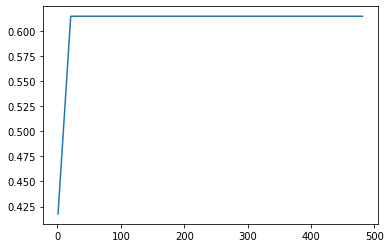

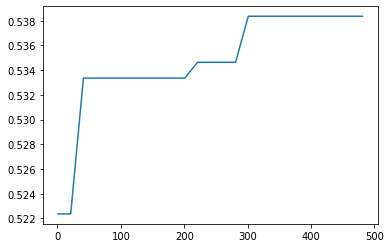

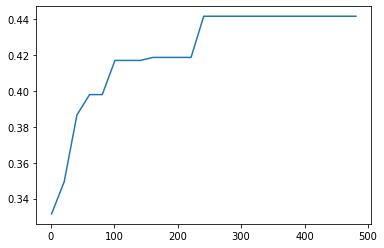

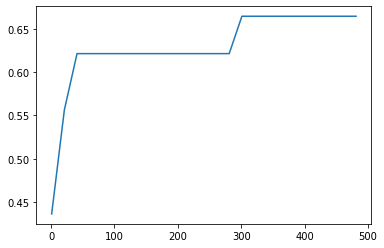

In [65]:
for elem in (a, b, c ,d):
    plt.figure()
    plt.plot(np.arange(1,n_max,step), elem)

In [23]:
attention = GC.generate_cam(img)

In [26]:
ids = np.unravel_index(np.argsort(-attention, axis=None), attention.shape)

In [98]:
at2 = attention.copy()
at2[(ids[0][:5000], ids[1][:5000])] = 0

In [48]:
batch_size2 = 10

In [49]:
img2 = img.tile(dims=(batch_size2,1,1,1))

In [50]:
img2.shape

torch.Size([10, 3, 208, 179])

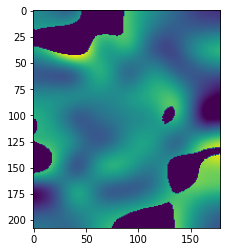

In [100]:
for k in range(batch_size2):
    img2[k,]

In [63]:
img2 = img[0,0,...]
img2[(ids[0][:5000], ids[1][:5000])] = 0

In [71]:
img2[(ids[0][:5000], ids[1][:5000])].shape

torch.Size([5000])

In [ ]:
def MoRF(X, model, exp_method, K=10, AUC=False, batch_size=512):
    """
    Most relevant first: measures the reliability of an explanation by testing 
    how fast the output decreases, while we progressively remove information (e.g., perturb pixels) 
    from the input 𝑥𝑥 (e.g., image), that appears as the most relevant by the explanation.
    Args:
        X: tensor, brain image, with shape (1, n_channels, **dims)
        exp_method: explanation method. Must have a get_explanations(self, input_image) attribute function
            which takes an image as input and returns a dictionary mapping branches to explanation maps
        K: number of relevant pixels to remove
        AUC: bool. If True: compute and return area under the curve obtained after removing successively 
            the K most relevant pixels.
            
    TO DO:
        - add several methods to perturb pixels
    """
    if torch.cuda.is_available():
        X = X.cuda()

    # explanations for original image
    expls = exp_method.get_explanations(X)
    
    # Indices of the sorted elements of the explanations:
    ind = dict()
    for target in expls:
        ind = np.unravel_index(np.argsort(-expls[target], axis=None), expls.shape)
    
        if AUC:
            pass
        else:
            # compute MoRF removing the K most relevant pixels
            MoRF
            perturbed_X = X.copy()
            perturbed_X[:,:,ind[0][:K],ind[1][:K]] = 0
            
        

# RANDOM

In [33]:
df_add_data[df_add_data.iloc[:,3].isna()].isna().sum(axis=0)

participant_id                                                                                      0
session_id                                                                                          0
sex                                                                                                 1
age                                                                                              1178
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Background_intensity                       1173
                                                                                                 ... 
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Posterior-Orbital-Gyrus_intensity    1173
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Planum-Polare_intensity               1173
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Planum-Polare_intensity              1173
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Precentral-Gyrus_intens

I am using working with the file '/network/lustre/dtlake01/aramis/datasets/adni/caps/caps_v2021.tsv' and using the 't1-volume' pipeline and the atlas 'AAL2'.
6267 samples (i.e. couples (participant_id, session_id)) do not have any volume value (i.e. NaN). 1 sample has no sex value and 1178 samples have no age values.


In [31]:
df_add_data.isna().sum(axis=0)

participant_id                                                                                      0
session_id                                                                                          0
sex                                                                                                 1
age                                                                                              1178
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Background_intensity                       6267
                                                                                                 ... 
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Posterior-Orbital-Gyrus_intensity    6267
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Planum-Polare_intensity               6267
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Right-Planum-Polare_intensity              6267
t1-volume_group-adni2021_atlas-Neuromorphometrics_ROI-Left-Precentral-Gyrus_intens

In [64]:

# initialize the model
convolutions = {
    'conv0':{
        'n_conv':1,
        'in_channels':None,
        'out_channels':16,
        'd_reduction': "MaxPooling"
    },
    'conv1':{
        'n_conv':1,
        'in_channels':None,
        'out_channels':32,
        'd_reduction': "MaxPooling"
    },
    'conv2':{
        'n_conv':1,
        'in_channels':None,
        'out_channels':32,
        'd_reduction': "MaxPooling"
    },
    'conv3':{
        'n_conv':1,
        'in_channels':None,
        'out_channels':64,
        'd_reduction': "MaxPooling"
    },
    'conv4':{
        'n_conv':1,
        'in_channels':None,
        'out_channels':128,
        'd_reduction': "MaxPooling"
    }
}
model = RandomArchitecture(convolutions,1,data_train.size)


# Define criterion and optimizer
criterion = get_criterion(loss)
optimizer = getattr(torch.optim, optimizer_name)(filter(lambda x: x.requires_grad, model.parameters()),
                                                   lr=learning_rate,
                                                   weight_decay=weight_decay)

In [8]:
class Options:
    def __init__(self):
        self.beginning_epoch = 0
        self.tolerance = 0
        self.patience = 10
        self.epochs = 10
        self.gpu = True
        self.batch_size = 1

In [9]:
train(model, train_loader, valid_loader, criterion, optimizer,False,'log_dir','model_dir', Options())

INFO:root:Beginning epoch 0.


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3080, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1625, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1632, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 5

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 185, in _worker_loop
    data = fetcher.fetch(index)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/clinicadl/tools/deep_learning/data.py", line 566, in __getitem__
    participant, session, cohort, slice_idx, label = self._get_meta_data(idx)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/clinicadl/tools/deep_learning/data.py", line 140, in _get_meta_data
    participant = self.df.loc[image_idx, 'participant_id']
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 889, in __getitem__
    return self._getitem_tuple(key)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 1060, in _getitem_tuple
    return self._getitem_lowerdim(tup)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 807, in _getitem_lowerdim
    section = self._getitem_axis(key, axis=i)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 1124, in _getitem_axis
    return self._get_label(key, axis=axis)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexing.py", line 1073, in _get_label
    return self.obj.xs(label, axis=axis)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/generic.py", line 3739, in xs
    loc = index.get_loc(key)
  File "/network/lustre/dtlake01/aramis/users/sasha.collin/miniconda3/envs/venv/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 3082, in get_loc
    raise KeyError(key) from err
KeyError: 5
